#### imports

In [4]:
import pandas as pd
import os
from scipy.stats import zscore
from scipy import stats
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from scipy.stats import beta
import numpy as np
from scipy.special import beta as beta_special
import matplotlib.pyplot as plt

#### Load the SeatGeek event data from file

Load the time series dataset of artists and events from the csv. The csv was aggregated as a sub-sample of data that lives in AWS.

In [5]:
combined_df = pd.read_csv('raw_seatgeek_events_data_combined_3_20_2025.csv')
combined_df['date'] = pd.to_datetime(combined_df['date'])
combined_df['filename_dt'] = pd.to_datetime(combined_df['filename_dt'])

print("Num Unique Events - ")
print(len(combined_df.event_id.unique()))

print("Num Unique Acts - ")
print(len(combined_df.act.unique()))

print("Num Unique Events + Acts - ")
unique_combinations = combined_df[['event_id', 'act', 'date']].drop_duplicates()
unique_combinations = unique_combinations.sort_values('event_id', ascending=True).reset_index(drop=True)
print(len(unique_combinations))

Num Unique Events - 
129966
Num Unique Acts - 
15408
Num Unique Events + Acts - 
138114


#### Filter the raw data loaded from file

From the paper, this section creates:

$$
\mathcal{D}_{\text{time}}
= \left\{ \left(\mu_t, \tilde{\mu}_t, \text{Max}_t, \text{Min}_t\right) \right\}_{t=1}^T.
$$

In [6]:
df = combined_df.copy()

# Filter
df = df[~df.act.str.contains("Fest")]
df = df[~df.city.str.contains("Las Vegas")]

# Artists that show up the most in the dataset
df3 = df["act"].value_counts().reset_index()
df3.columns = ["act", "count"]
top_n_df = df3.sort_values(by="count", ascending=False)[0:1000]
#display(top_n_df[0:5])

df = df[df.act.isin(top_n_df.act.unique())]

df["date"] = pd.to_datetime(df["date"])

df = df.sort_values(
    by=["event_id", "date", "act", "filename_dt"], ascending=[True, True, True, True]
)

df = df.groupby(["event_id", "date", "act"]).filter(
    lambda x: np.mean(x.lowest_price) >= 25
)

df = df.groupby(["event_id", "date", "act"]).filter(lambda x: len(x) >= 25)

df = df.groupby(["event_id", "date", "act"]).filter(
    lambda x: not x.drop(columns="event_id").isnull().values.any()
)

# Ensure that the data for each event in the set goes
# all the way up to the actual date of the event
# In this way, the time-series snapshot we take is always
# during the same relative period leading up to an event.

# Group by event_id and act, find the most recent filename_dt
recent_filename_dt = df.groupby(["event_id", "act"])["filename_dt"].transform("max")

# Calculate the difference between date and the most recent filename_dt
df["diff"] = (df["date"] - recent_filename_dt).dt.days

# Filter rows where the difference is <= 1 day
filtered_df = df[df["diff"] <= 1]

# Drop the 'diff' column if no longer needed
filtered_df = filtered_df.drop(columns=["diff"])
df = filtered_df

# Most represented artists after filter
a = filtered_df["act"].value_counts().reset_index()
a.columns = ["act", "count"]
t = a.sort_values(by="count", ascending=False)[0:1000]

df = df.dropna()

# This gets used in later cells
df_k = df.copy()

print("Num Unique Events - ")
print(len(df_k.event_id.unique()))

print("Num Unique Acts - ")
print(len(df_k.act.unique()))

print("Num Unique Events + Acts - ")
unique_combinations = df_k[['event_id', 'act', 'date']].drop_duplicates()
unique_combinations = unique_combinations.sort_values('event_id', ascending=True).reset_index(drop=True)
print(len(unique_combinations))

print("Complete.")

Num Unique Events - 
27680
Num Unique Acts - 
971
Num Unique Events + Acts - 
28410
Complete.


In [7]:
# Select an event id to view its time series data
# print(list(df_k.event_id.unique())[0:50])

# print(list(df_k.act.unique())[0:150])

# a = df_k[df_k.act == 'Buddy Guy']
# print(list(a.event_id.unique())[0:50])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Buddy Guy - Ticket Price Statistics over Time; Wilbur Theatre - Boston; 2023-10-03 20:00:00


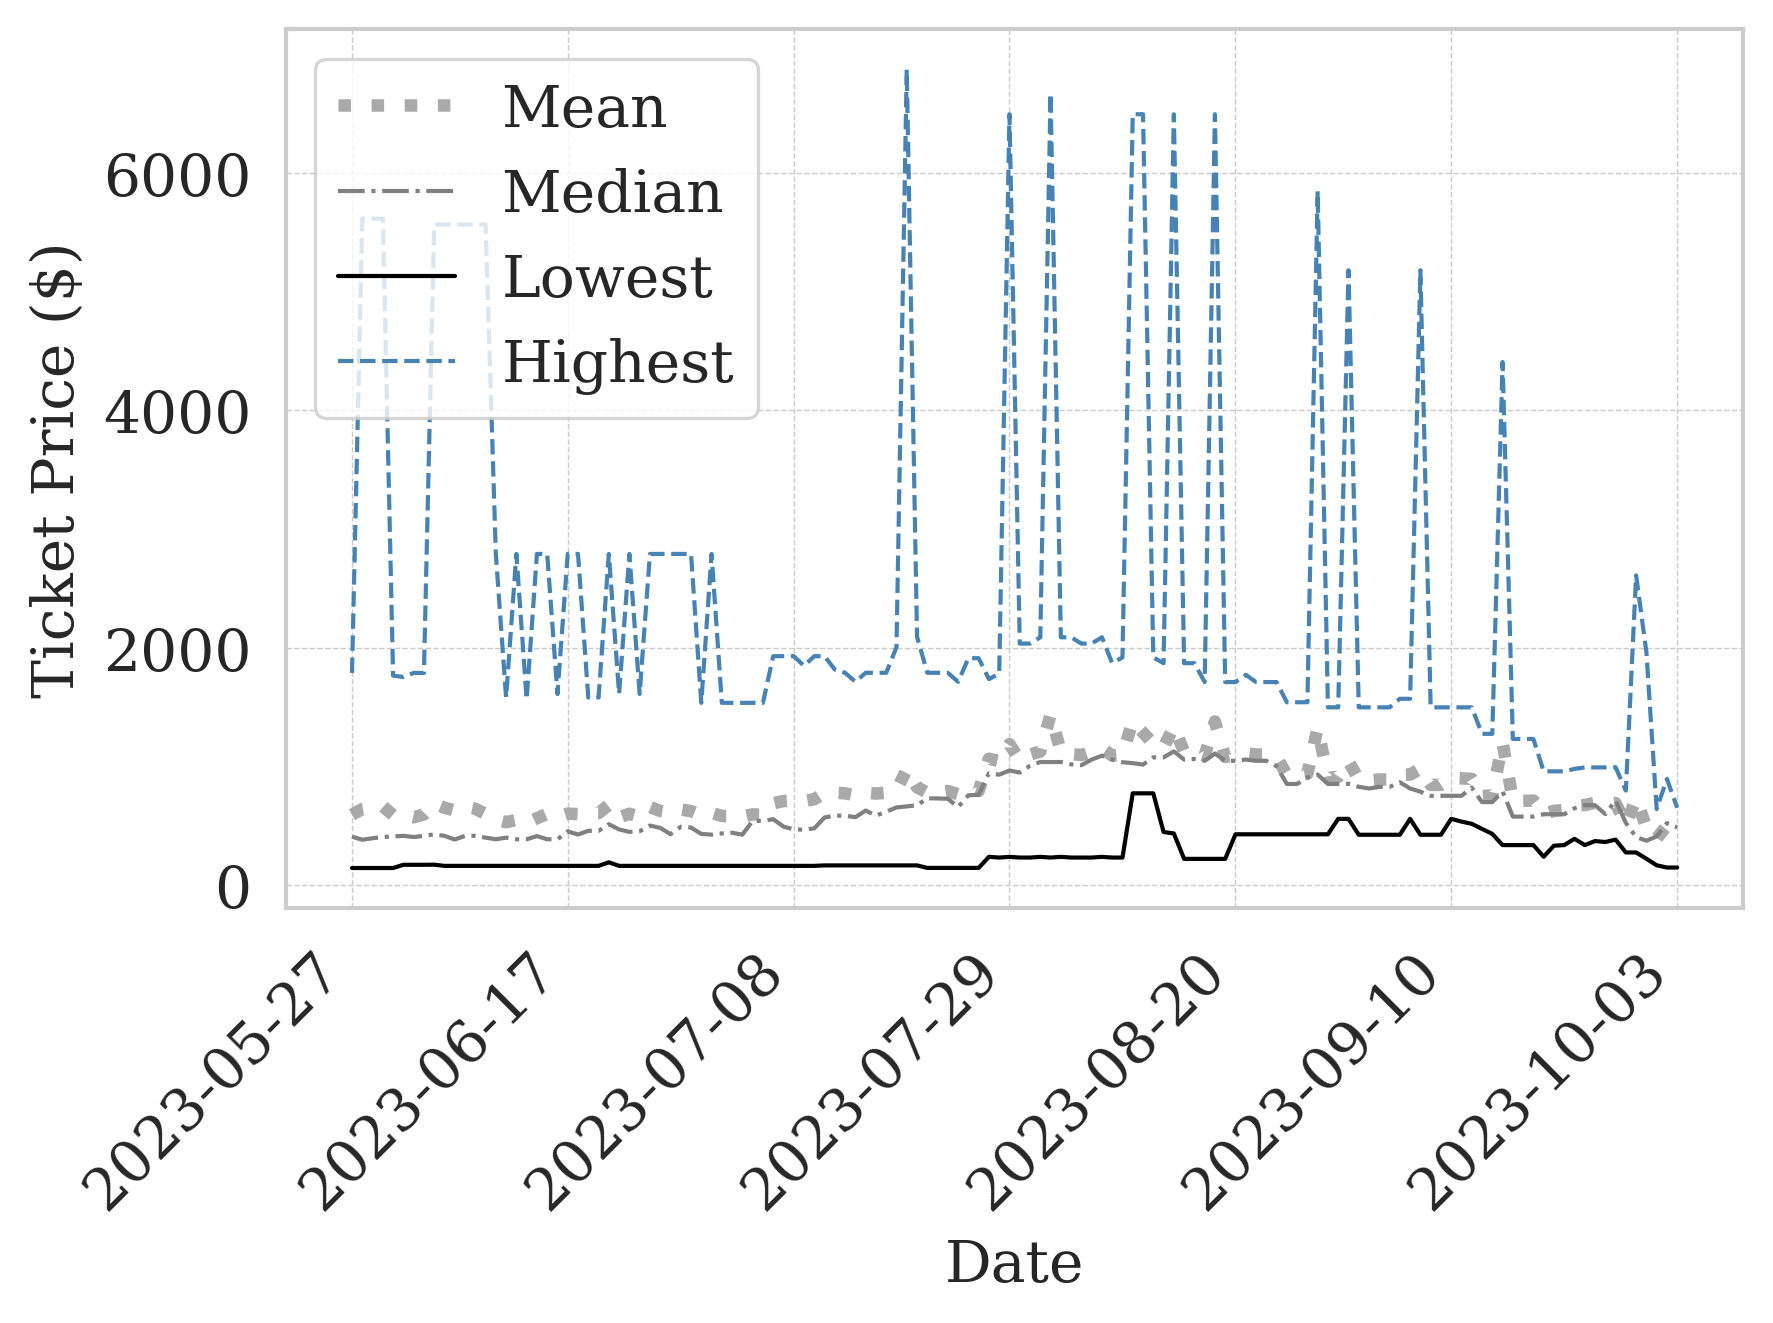

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set(style="whitegrid", context="paper")

#rcParams['text.usetex'] = True
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
# Use Type 1 fonts in PDFs and set serif fonts for consistency
rcParams['pdf.use14corefonts'] = True  
#plt.rc('text', usetex=True)  # Enable LaTeX for text rendering
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
#rcParams['text.latex.preamble'] = r'\usepackage{amsmath}\usepackage{lmodern}'
plt.rc('font', family='serif')
#plt.rc('font', serif=['Computer Modern Roman'])

fsize = 14

# Select & sort the event
# event id is regenerated as unique so as not to share seatgeek ids
df = df_k[df_k.event_id == 563].sort_values('filename_dt').reset_index(drop=True)
df['filename_dt'] = pd.to_datetime(df['filename_dt'])

# We'll plot against the integer x‐axis so ticks can be evenly spaced:
x = np.arange(len(df))

fig, ax = plt.subplots(figsize=(6, 4.5), dpi=300)

# Plot each series with LaTeX legend entries
ax.plot(x, df['average_price'],
        label=r'Mean',
        color='darkgrey', linestyle=':',  linewidth=3)
ax.plot(x, df['median_price'],
        label=r'Median',
        color='gray',    linestyle='-.', linewidth=1)
ax.plot(x, df['lowest_price'],
        label=r'Lowest',
        color='black',   linestyle='-',  linewidth=1)

ax.plot(x, df['highest_price'],
        label=r'Highest',
        color='steelblue', linestyle='--', linewidth=1)

# Title printed to console
print(f"{df.act.iloc[0]} - Ticket Price Statistics over Time; {df.venue.iloc[0]}; {df.date.iloc[0]}")

# Axis labels
ax.set_xlabel('Date', fontsize=fsize)
ax.set_ylabel('Ticket Price (\$)', fontsize=fsize)

# Choose num_ticks evenly‐spaced ticks along x
num_ticks = 7
tick_locs = np.linspace(0, len(df)-1, num_ticks, dtype=int)
tick_labels = df['filename_dt'].dt.strftime('%Y-%m-%d').iloc[tick_locs]

ax.set_xticks(tick_locs)
ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=fsize)
ax.tick_params(axis='y', labelsize=fsize)

# Legend in upper left
ax.legend(fontsize=fsize, loc='upper left', facecolor='white', frameon=True)

# Light grid
ax.grid(True, which='both', linestyle='--', linewidth=0.35, alpha=1)

plt.tight_layout()
plt.savefig(
    'figure_example_time_series.eps',
    format='eps',
    dpi=300,
    bbox_inches='tight'
)
plt.show()

#### Create labeled ML dataset of economic signatures for classification

From the paper, this section calculates:

$$
\bar{x} = \frac{1}{|T'|} \sum_{t \in T'} x_t,
\quad x \in \{\mu, \tilde{\mu}, \text{Max}, \text{Min}\},
$$

to generate:

$$
\mathbf{z}_i 
= \left[ \bar{\mu}_i, \ \bar{\tilde{\mu}}_i, \ \overline{\text{Max}}_i, \ \overline{\text{Min}}_i \right]^\top.
$$
$$
\mathcal{D}_{\text{basic}} = f\left( \mathcal{D}_{\text{time}} \right)
= \left\{ \left( \mathbf{z}_i, y_i \right) \right\}_{i=1}^n.
$$

and

The Jacobian scaled Beta distribution is given by:
$$
f(x; \alpha_i, \beta_i, \text{Min}_i, \text{Max}_i) = 
$$

$$
\frac{(x - \text{Min}_i)^{\alpha_i  
- 1} (\text{Max}_i - x)^{\beta_i - 1}}{(\text{Max}_i - \text{Min}_i)^{\alpha_i + \beta_i  
- 1} B(\alpha_i, \beta_i)},
$$

##### Composite Quantile and Moment Matching

$$
\mu_i = \text{Min}_i + \frac{\alpha_i}{\alpha_i + \beta_i} (\text{Max}_i -  
\text{Min}_i),
$$

$$
\tilde{\mu}_i \approx \text{Min}_i + (\text{Max}_i - \text{Min}_i) \left(  
\frac{\alpha_i - \frac{1}{3}}{\alpha_i + \beta_i - \frac{2}{3}}\right).
$$

We first scale the mean and median to the standard interval $[0, 1]$:

$$
s = \frac{\mu_i - \text{Min}_i}{\text{Max}_i - \text{Min}_i}, \quad m =  
\frac{\tilde{\mu}_i - \text{Min}_i}{\text{Max}_i - \text{Min}_i}.
$$

From the mean equation, we express $\beta_i$ in terms of $\alpha_i$ and the  
scaled mean $s$:

$$
\beta_i = \alpha_i \left( \frac{1 - s}{s} \right).
$$

Substituting this into the equation for the median gives:

$$
m = \frac{\alpha_i - \frac{1}{3}}{\frac{\alpha_i}{s} - \frac{2}{3}},
$$

which simplifies to:

$$
\alpha_i = \frac{ s (2 m - 1) }{ 3 ( m - s ) }, \quad \beta_i = \frac{ (1 -  
s)(2 m - 1) }{ 3 ( m - s ) }.
$$

providing the final $\mathcal{D}_{\alpha \beta}$ representation written to file for training and analysis:

$$
\mathbf{z}_i 
= \left[ \bar{\mu}_i, \ \bar{\tilde{\mu}}_i, \ \overline{\text{Max}}_i, \ \overline{\text{Min}}_i, 
\ \alpha_i, \ \beta_i \right]^\top,
$$

$$
\mathcal{D}_{\alpha \beta} 
= f\left( \mathcal{D}_{\text{basic}} \right)
= \left\{ \left( \mathbf{z}_i, y_i \right) \right\}_{i=1}^n.
$$

In [ ]:
def compute_alpha(min_value, max_value, mu, median):
    """
    Compute alpha based on the given mean (mu), median, minimum, and maximum values.
    Matches derivation in paper.

    Parameters:
    - mu: Mean of the data.
    - median: Median of the data.
    - min_value: Minimum value in the data.
    - max_value: Maximum value in the data.

    Returns:
    - alpha: The computed alpha value.
    """
    try:
        s = (mu - min_value) / (max_value - min_value)
        m = (median - min_value) / (max_value - min_value)
        numerator = s * (2 * m - 1)
        denominator = 3 * (m - s)
        alpha = numerator / denominator
        return alpha
    except ZeroDivisionError:
        print("Error: Division by zero encountered in compute_alpha. Check that m != s.")
        return None


def compute_beta(min_value, max_value, mu, median):
    """
    Compute beta based on the given mean (mu), median, minimum, and maximum values.
    Matches derivation in paper.

    Parameters:
    - mu: Mean of the data.
    - median: Median of the data.
    - min_value: Minimum value in the data.
    - max_value: Maximum value in the data.

    Returns:
    - beta: The computed beta value.
    """
    try:
        s = (mu - min_value) / (max_value - min_value)
        m = (median - min_value) / (max_value - min_value)
        numerator = (1 - s) * (2 * m - 1)
        denominator = 3 * (m - s)
        beta = numerator / denominator
        return beta
    except ZeroDivisionError:
        print("Error: Division by zero encountered in compute_beta. Check that m != s.")
        return None


In [ ]:
df = df_k.copy()
# df = df[["event_id","filename_dt","average_price", "date", "act",
#          "median_price","lowest_price", "highest_price", 
#          "listing_count", "popularity", "score"]]
df = df[["event_id","filename_dt","average_price", "date", "act",
         "median_price","lowest_price", "highest_price", 
         "listing_count", "popularity", "score", "day_of_week"]]
df['filename_dt'] = pd.to_datetime(df['filename_dt'])

# Display the original DataFrame
before_grouping = df.copy()

# Grouping and average the last n entries of the event_id
# This represents our snapshot in time leading up to an event
# It is these snapshots that will be used in our models 
# to classify / distinguish artists
def aggregate_last_n_entries(group):
    # Select the last N entries based on the largest 'filename_dt' values
    last_n = group.nlargest(14, 'filename_dt') # 14 for two weeks
    
    # Ensure 'date' and 'filename_dt' are datetime objects
    last_n['date'] = pd.to_datetime(last_n['date'])
    last_n['filename_dt'] = pd.to_datetime(last_n['filename_dt'])
    
    # Get the 'date' and 'filename_dt' of the latest entry
    a = last_n['date'].iloc[0]
    b = last_n['filename_dt'].iloc[0]
    
    # Calculate the difference in days
    c = (a - b).days
    
    # Compute the mean of the specified columns
    x = last_n[['average_price', 'median_price', 'lowest_price', 
                'highest_price', 'listing_count', 'score', 'popularity']].mean()
    x['difference_days'] = c
    
    return x

#grouped_df = df.groupby(['event_id', 'date', 'act']).apply(aggregate_first_n_entries).reset_index()
grouped_df = df.groupby(['event_id', 'date', 'act']).apply(aggregate_last_n_entries).reset_index()

# method of moments

# Data from the image
min_price = grouped_df["lowest_price"] # 61
max_price = grouped_df["highest_price"] #515
mean_price = grouped_df["average_price"] #200  # Approximate mean based on the bar heights
median_price = grouped_df["median_price"] #180  # Approximate median based on the bar heights

# Calculate range and midpoint
R = max_price - min_price
M = median_price - min_price

# Estimate beta parameters using the method of moments
# alpha_param = ((mean_price - min_price) * (2*median_price - min_price - max_price)) / ((median_price - mean_price) * (max_price - min_price))
# beta_param = alpha_param * (max_price - mean_price) / (mean_price - min_price)
alpha_param = compute_alpha(min_price, max_price, mean_price, median_price)
beta_param = compute_beta(min_price, max_price, mean_price, median_price)

# # Generate x values for plotting
num_pdf_feat = 15
x = np.linspace(0, 1, num_pdf_feat)

# Add distribution info
grouped_df["alpha"] = alpha_param
grouped_df['alpha'] = grouped_df['alpha'].fillna(0)
grouped_df["beta"] = beta_param
grouped_df['beta'] = grouped_df['beta'].fillna(0)

#df_out = pd.merge(grouped_df, df_out, on=['event_id', 'date', 'act'], how='inner')
df_out = grouped_df

# remove zero rows
columns_to_check = ["median_price", "average_price", "alpha", "beta", "lowest_price", "highest_price"]
df_out = df_out[~(df_out[columns_to_check].sum(axis=1) == 0)]

# Write the transformed dataset to file for analysis
#df_out.to_csv('event_labels_1_18_2025_last_N_days.csv',index=False)

print("Num unique events in saved file")
print(len(df_out.event_id.unique()))
print("Num unique acts in saved file")
print(len(df_out.act.unique()))

#### The End

In [ ]:
print("qed")


# Comment this out to execute the cells below 
raise KeyboardInterrupt